In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import sys

sys.path.append("..")
from data_utils import data_process, batchify, get_batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [4]:
from torch.utils.data import dataset
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


train_iter = WikiText2(split="train")
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter, vocab, tokenizer)
val_data = data_process(val_iter, vocab, tokenizer)
test_data = data_process(test_iter, vocab, tokenizer)

batch_size = 32
eval_batch_size = 10
train_data = batchify(train_data, batch_size, device)
val_data = batchify(val_data, eval_batch_size, device)
test_data = batchify(test_data, eval_batch_size, device)

In [5]:
idx2word = {i: x for i, x in enumerate(vocab.get_itos())}

def to_sentence(x):
    return " ".join([idx2word[int(idx)] for idx in x])

def to_tokens(x):
    return [idx2word[int(idx)] for idx in x]

data, _ = get_batch(train_data, batch_size*2, bptt=30)
to_sentence(data[:, 0])

'third game in the valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game'

## Model

In [6]:
from torch import nn, Tensor
from multihead_attention import MultiheadAttention
from positional_encoding import PositionalEncoding
from transformer_encoder import TransformerEncoder, TransformerEncoderLayer

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float("-inf"), diagonal=1)


class Model(nn.Module):
    def __init__(self, n_tokens, D, Dff, B, n_heads, n_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, D)
        self.pe = PositionalEncoding(D, dropout=0)
        # self.encoder = MultiheadAttention(D, n_heads, bias=True)
        
        encoderLayer = TransformerEncoderLayer(D, n_heads, Dff)
        self.encoder = TransformerEncoder(encoderLayer, n_layers)
        self.decoder = nn.Linear(D, n_tokens)
        
        self._init_parameters()
    
    def _init_parameters(self):
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-0.1, 0.1)

    def forward(self, src, attn_mask):
        """ 
        Args: 
            src: tensor, shape [B, N]
            attn_mask: tensor, shape [N, N]
        Returns:
            output: tensor, shape[B, N, n_tokens]
            attn_weights: list[tensor], shape[n_layers, [B, n_heads, N, N]]
        """
        # (B, N, D)
        src = self.embedding(src)
        src = self.pe(src)
        
        # (B, N, D), (B, n_heads, N, N)
        attn_output, attn_weights =self.encoder(src, attn_mask)
        
        # (B, N, n_tokens)
        output = self.decoder(attn_output)
        return output, attn_weights
        
        


## Train

In [7]:
import random
import time

N, D, Dff = 15, 16, 64
n_heads, n_layers = 4, 2
n_tokens = len(vocab)        

lr = 5.0
epochs, log_interval = 3, 200

torch.manual_seed(12)
model = Model(n_tokens, D, Dff, batch_size, n_heads, n_layers=n_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

src_mask = generate_square_subsequent_mask(N).to(device)

In [10]:
model.train()
# n_batches_per_epoch = train_data.size(0) // N
n_batches_per_epoch = 1000

all_losses = []
total_epoch_loss = 0
t_epoch = time.time()

for e in range(1, epochs+1):
    # since train_data is a tensor of shape [total_seq_len/batch_size, batch_size], randomly index batches
    indices = [random.randint(0, train_data.size(0)-N) for _ in range(n_batches_per_epoch)]
    total_loss = 0

    t_interval = time.time()
    for i, idx in enumerate(indices):
        data, targets = get_batch(train_data, idx, bptt=N)

        output, _ = model(data.t(), src_mask)
        loss = criterion(output.view(-1, n_tokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_epoch_loss += loss.item()

        if i % log_interval == 0 and i !=0:
            lr = scheduler.get_last_lr()[0]
            avg_loss = total_loss / log_interval
            all_losses.append(avg_loss)
            
            ms_per_batch = (time.time() - t_interval) * 1000 / log_interval
            sec_remaining = int((n_batches_per_epoch - i) * ms_per_batch / 1000)

            t_interval = time.time()
            total_loss = 0

            msg = f"epoch: {e} || batch: ({i}/{n_batches_per_epoch}) || loss: {avg_loss:<.3f} || lr: {lr:<.3f}"
            msg += f"|| ms/batch: {ms_per_batch:<.3f} || sec remaining: {sec_remaining}"
            print(msg)
            
            
    lr = scheduler.get_last_lr()[0]
    sec_per_epoch = time.time() - t_epoch
    avg_epoch_loss = total_epoch_loss/ n_batches_per_epoch
    
    t_epoch = time.time()
    total_epoch_loss = 0
    scheduler.step()
    
    print("-" * 80)
    print(f"epoch {e} || epoch loss: {avg_epoch_loss} || lr: {lr:<.3f} || sec per epoch: {sec_per_epoch:<.3f}\n")

epoch: 1 || batch: (200/1000) || loss: 8.232 || lr: 5.000|| ms/batch: 129.624 || sec remaining: 103
epoch: 1 || batch: (400/1000) || loss: 7.390 || lr: 5.000|| ms/batch: 132.762 || sec remaining: 79
epoch: 1 || batch: (600/1000) || loss: 7.203 || lr: 5.000|| ms/batch: 130.624 || sec remaining: 52
epoch: 1 || batch: (800/1000) || loss: 7.119 || lr: 5.000|| ms/batch: 119.627 || sec remaining: 23
--------------------------------------------------------------------------------
epoch 1 || epoch loss: 7.395725042819977 || lr: 5.000 || sec per epoch: 126.953

epoch: 2 || batch: (200/1000) || loss: 6.982 || lr: 4.750|| ms/batch: 129.656 || sec remaining: 103
epoch: 2 || batch: (400/1000) || loss: 6.850 || lr: 4.750|| ms/batch: 132.822 || sec remaining: 79
epoch: 2 || batch: (600/1000) || loss: 6.764 || lr: 4.750|| ms/batch: 131.404 || sec remaining: 52
epoch: 2 || batch: (800/1000) || loss: 6.726 || lr: 4.750|| ms/batch: 131.273 || sec remaining: 26
--------------------------------------------

## Plot losses

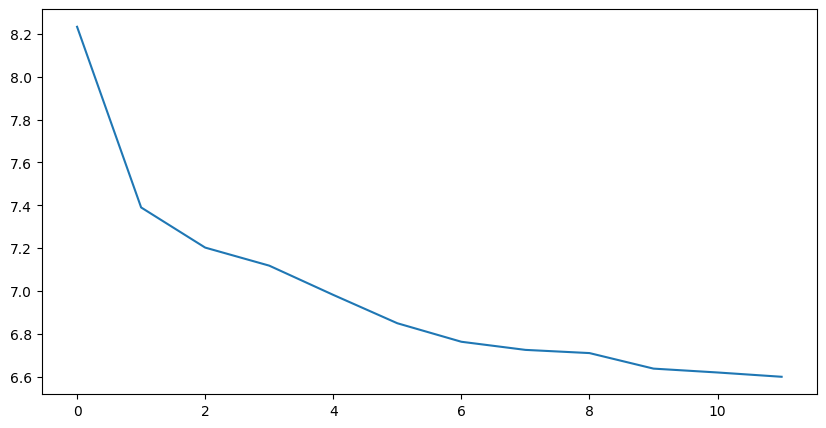

In [11]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(all_losses)
plt.show()

## Visualize attention weights

output sentence: the the . the the the . and . . . . . the <unk>


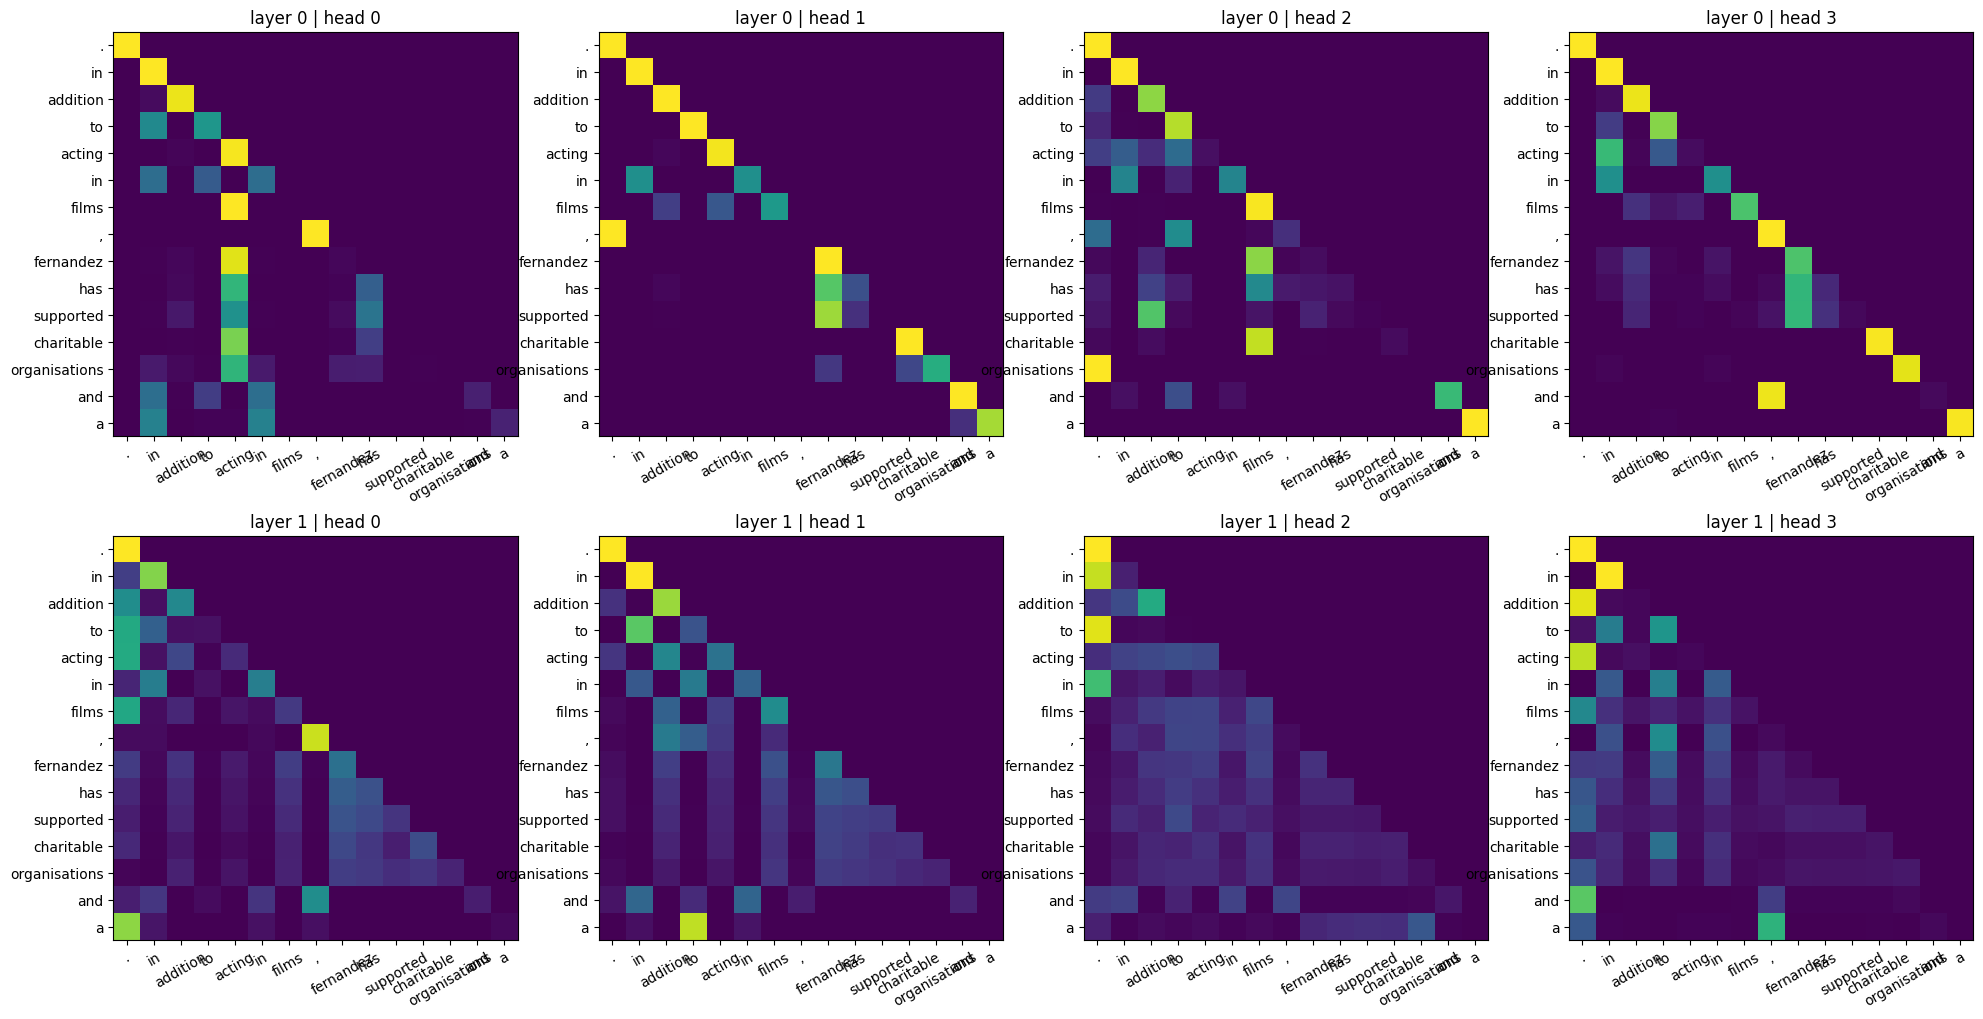

In [13]:
import random

model.eval()

idx = random.randint(0, train_data.size(0))
data, targets = get_batch(train_data, idx , bptt=N)
data = data[:, :1]
output, attn_weights = model(data.t(), src_mask)

labels = to_tokens(data.squeeze())
output_sentence = to_sentence(output.argmax(-1).squeeze())
print(f"output sentence: {output_sentence}")

attn_w = torch.concat(attn_weights, dim=0).view(-1, N, N).cpu().detach()
n_cols = 4
n_rows = attn_w.size(0) // n_cols

_, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
for i, w in enumerate(attn_w):
    r, c = i // n_cols, i %n_cols
    l, h = i // n_heads, i % n_heads
    
    ax[r, c].imshow(w)
    ax[r, c].set_title(f"layer {l} | head {h}")
    ax[r, c].set_xticks(range(N))
    ax[r, c].set_yticks(range(N))
    ax[r, c].set_xticklabels(labels, rotation=30)
    ax[r, c].set_yticklabels(labels, rotation=0)